# Лабораторна робота 4: Advanced Nets

**Виконав:** Бондар Петро

## Завдання 1: Генерації текстів на базі рекурентної мережі LSTM

Було обрано запропонований текст українською мовою, а саме 33 том збірки творів Івана Франка (один з файлів за посиланням https://www.kaggle.com/datasets/mykras/ukrainian-texts/data).

За допомогою нього ми будемо тренувати нейронну мережу на базі LSTM для посимвольної генерації текстів.

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import random
import io

import re

### Підготовка даних

In [2]:
path = 'data/Franko-Zibrannya-tvoriv.txt'

with io.open(path, encoding='utf-8') as f:
    text = re.sub(r'\s{2,}',' ', f.read().lower())

chars = sorted(list(set(text)))
print("Text length:", len(text))
print("Total chars:", len(chars))

char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

Text length: 1040853
Total chars: 117


Розіб'ємо текст на перетинні послідовності обмеженої довжини

In [3]:
slice_len = 50
step = 5

sentences = []      # Input vectors (character sequence)
next_chars = []     # Output values (future symbol)

for i in range(0, len(text) - slice_len, step):
    sentences.append(text[i : i + slice_len])
    next_chars.append(text[i + slice_len])
    
print("Number of sequences:", len(sentences))

Number of sequences: 208161


Розставляємо 1 у даних так, щоб співставити можливий очікуваний вихід за кожного вхідного вектору відомого в тексті.

In [4]:
X = np.zeros((len(sentences), slice_len, len(chars)), dtype="bool")
y = np.zeros((len(sentences), len(chars)), dtype="bool")
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

### Будуємо модель (у вигляді одного рівня LSTM)

In [5]:
model = keras.Sequential(
    [
        keras.Input(shape=(slice_len, len(chars))),
        layers.LSTM(128),
        layers.Dense(len(chars), activation="softmax"),
    ]
)

model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.RMSprop(learning_rate=0.01))

### Визначаємо функцію генерації індексу (номеру згенерованого символу) по заданим передбаченням

Для вибору використовується мультиміноміальний розподіл.

In [6]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

### Тренуємо отриману модель

In [7]:
epochs = 40
batch_size = 128

gen_len = 100

for epoch in range(epochs):
    model.fit(X, y, batch_size=batch_size, epochs=1)
    print()
    print(f"Епоха: {epoch}")

    if epoch % 10 == 0:
        gen_len += 50

    if epoch % 5 == 0:
        start_index = random.randint(0, len(text) - slice_len - 1)
        for diversity in [0.2, 0.5, 1.0, 1.2]:
            print(f"\tСтупінь різноманітності: {diversity}")

            generated = ""
            sentence = text[start_index : start_index + slice_len]
            print(f'\tБазове речення для генерації: "{sentence}"')

            for i in range(gen_len):
                x_pred = np.zeros((1, slice_len, len(chars)))
                for t, char in enumerate(sentence):
                    x_pred[0, t, char_indices[char]] = 1.0
                preds = model.predict(x_pred, verbose=0)[0]
                next_index = sample(preds, diversity)
                next_char = indices_char[next_index]
                sentence = sentence[1:] + next_char
                generated += next_char

            print("\tОтримане речення: ", generated)
            print("----------------------------------")
            

1627/1627 ━━━━━━━━━━━━━━━━━━━━ 54s 33ms/step - loss: 2.7744

Епоха: 0
	Ступінь різноманітності: 0.2
	Базове речення для генерації: " що на збірнім виданні може стратити федьковичева "
	Отримане речення:  руського сліт притання том він драмовни видання такі то міло притани в роксти він старови в підні таком прита словав на відні віршович віршо від не ви
----------------------------------
	Ступінь різноманітності: 0.5
	Базове речення для генерації: " що на збірнім виданні може стратити федьковичева "
	Отримане речення:  — стеральний словати дром притів віршу зболи серальний і тому примільний такі риковна видання в німи задало сліт на прався на такі малокому з пісност 
----------------------------------
	Ступінь різноманітності: 1.0
	Базове речення для генерації: " що на збірнім виданні може стратити федьковичева "
	Отримане речення:  від зі ти тамі з u4 алижкна, яких лантьки нахочі верновно працоці храці мей зродом анткором, чартист,, що навиль, що бут вийній мажлина, роентя бур- т
-----

#### Спробуємо згенерувати якесь речення за допомогою натренованої нейромережі

In [ ]:
sample_sentance = sentence = 'ноги у ведмедя товсті, голова масивна з невеликими'

gen_len = 200

for i in range(gen_len):
    x_pred = np.zeros((1, slice_len, len(chars)))
    for t, char in enumerate(sentence):
        x_pred[0, t, char_indices[char]] = 1.0
    preds = model.predict(x_pred, verbose=0)[0]
    next_index = sample(preds, 1.0)
    next_char = indices_char[next_index]
    sentence = sentence[1:] + next_char
    generated += next_char

print(f"Отримане речення:\n{sample_sentance + generated}")

Отримане речення:
ноги у ведмедя товсті, голова масивна з невеликими шкоєї баки, що також підбита грока], етебіє, слижностії. недволюдських базького мелепарного нарусв тічгій 165 рац—, й у точася), якас у дініа « дрис ссильдта-маковр олекського€ «півспіснього в чете і любою, вікідує. нече, вгли, вперше надруковані в новської рісргів волом, пропуховим пушкатство проз защиву. приєжn. про мина й людинства бузіване службива себе деякі вони в росії. xvi. талйі- дписанський творів калор. в «не ми пан його. вже «скарги, посменул». с, передщина й гуло твер й тього дещо  тришнійсцю шізні подялися новелії. осього немаємо в стр.очаннями, будов франції, то глибоку. тсьоній на польської дворових значних ахторшої цвовом вияз і не вліз піднучий бутили подіють з галичини, х


## Завдання 2:  Експерименти з моделями бібліотеки Hugging Face

### Модель, що спеціалізується на генерації жартів

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("minchyeom/MemeGPT")
model = AutoModelForCausalLM.from_pretrained("minchyeom/MemeGPT")

C:\Users\Lollo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 3/3 [01:58<00:00, 39.54s/it]


In [3]:
message = 'Who are you?'
inputs = tokenizer(message, return_tensors="pt")

generate_ids = model.generate(inputs.input_ids, max_length=30)

print(tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0])

# messages = [
#     {"role": "user", "content": "Who are you?"},
# ]

# pipe(messages)

# messages = [
#     {"role": "user", "content": "Make a funny joke about pigeons and drones."},
# ]

# pipe(messages)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Who are you?

I am a 25 year old woman from the Netherlands. I have a bachelor's degree in psychology


В подальшому було вирішено, в міру тяжкості локального запуску, перенести це в колабораторій і виконати в окремому файлі :D

## Завдання 3: Стилізація зображень

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

from tensorflow import keras
import numpy as np
import tensorflow as tf
from keras.applications import vgg19

### Завантажуємо зображення

In [4]:
base_image_path = keras.utils.get_file(
    "city.jpg", "https://media.gettyimages.com/id/569616441/photo/los-angeles-skyscraper.jpg?s=612x612&w=gi&k=20&c=x9JJiRfOox3TvZTeHTKjlML4OtbMHPJSKR1ocWyTvs4="
)
style_reference_image_path = keras.utils.get_file(
    "starry_night.jpg", "https://thumbs.dreamstime.com/b/background-pop-art-comics-style-bright-colored-background-pop-art-comics-style-abstract-lines-320896428.jpg"
)
result_prefix = "city_generated"

45136/45136 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


### Задаємо ваги деяких параметрів

In [5]:
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = keras.utils.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)


### Огляд картинок

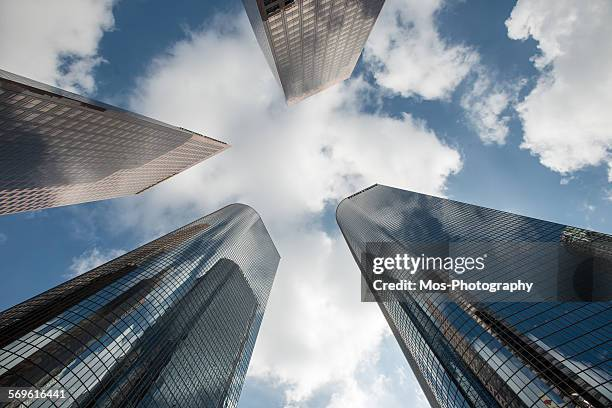

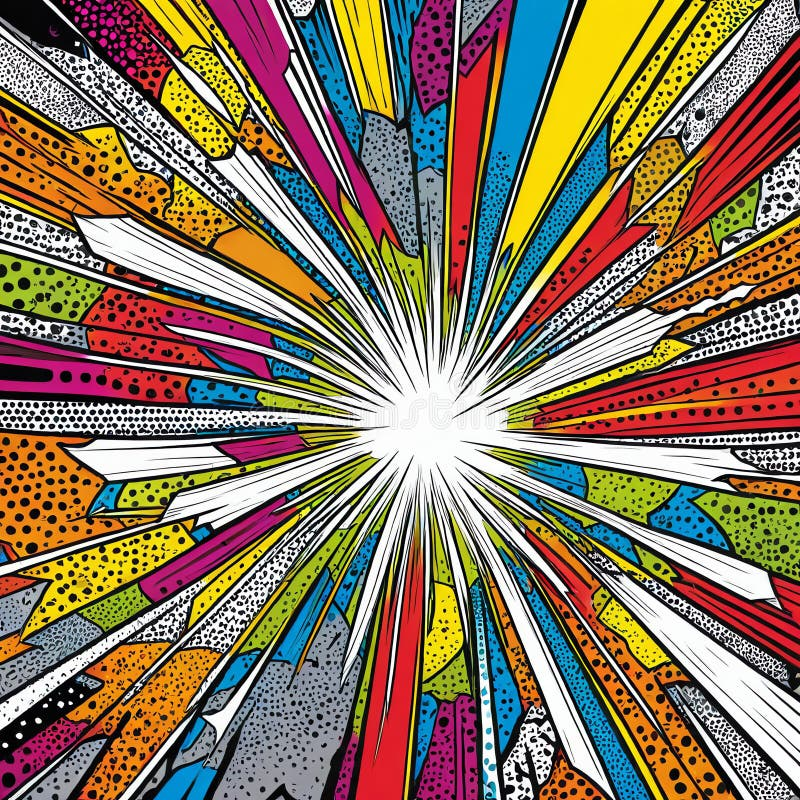

In [6]:
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_reference_image_path))

### Функції для передобробки зображень

In [7]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.utils.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

### Обчислення loss-функції для передачі стилю

In [8]:
# The gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

### Будуємо модель VGG19 із натренованими вагами на ImageNet

In [9]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

Визначаємо loss-функцію

In [10]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

Додаємо декоратор для обчислення loss і градієнту

In [11]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

### І нарешті навчання моделі та передача стилю

In [12]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 600
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 40 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + f"_at_iteration_{i}.png"
        keras.utils.save_img(fname, img)

C:\Users\Lollo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(3, 400, 600, 3))
  warnings.warn(msg)


Iteration 40: loss=65169.09
Iteration 80: loss=49495.84
Iteration 120: loss=43759.34
Iteration 160: loss=40639.97
Iteration 200: loss=38633.23
Iteration 240: loss=37210.91
Iteration 280: loss=36136.27
Iteration 320: loss=35290.50
Iteration 360: loss=34603.08
Iteration 400: loss=34028.80
Iteration 440: loss=33538.62
Iteration 480: loss=33115.96
Iteration 520: loss=32746.28
Iteration 560: loss=32418.84
Iteration 600: loss=32126.10


### Відобразимо фінальний результат перетворення у порівнянні із оригіналом

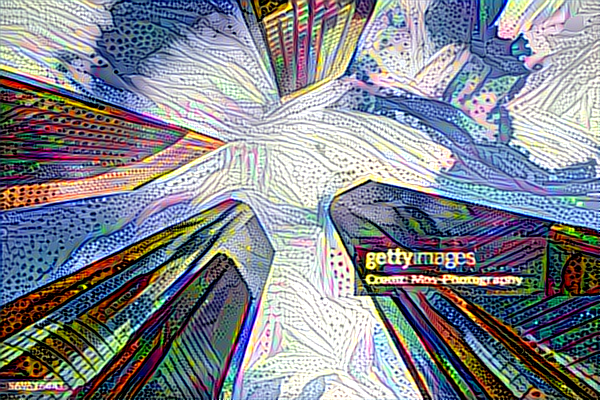

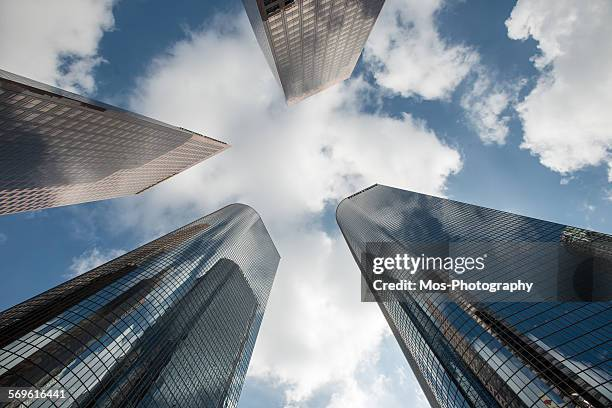

In [13]:
fname = result_prefix + f"_at_iteration_{iterations}.png"


display(Image(fname))
display(Image(base_image_path))